In [8]:
%load_ext autoreload
%autoreload 2
%pylab inline
import pandas as pd
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


# Dataframes
command: disjoint speaker split

In [2]:
dataframe_dir = '/home/muncok/DL/dataset/SV_sets/dataframes/'
data_dir = '/home/muncok/DL/dataset/SV_sets/speech_commands/'
command_df = pd.read_pickle(os.path.join(dataframe_dir,'Command_Dataframe.pkl'))

# SI Train

In [3]:
#TODO: correct splits
all_spks = command_df.spk.unique()
all_sents = command_df.sent.unique()
uttrs_counts = command_df.spk.value_counts()
sv_spks = list(uttrs_counts[:10].index)  # top 5 speakers whose number of recored uttrs is high
si_df = command_df[~command_df.spk.isin(sv_spks)]
si_spks = list(si_df.spk.unique())
sv_df = command_df[command_df.spk.isin(sv_spks)]

In [4]:
import random 

# command dataset is disjoint along speakers.
si_spk_train = si_df[si_df.set == 'train']
si_spk_val = si_df[si_df.set == 'val']
si_spk_test = si_df[si_df.set == 'test']
print("[spk] train:{}, val:{}, test:{}".format(len(si_spk_train), len(si_spk_val), len(si_spk_test)))

# spliting along the sents
random.shuffle(all_sents)
train_sent = all_sents[:20]
val_sent = all_sents[20:25]
test_sent = all_sents[25:]
si_sent_train = si_df[si_df.sent.isin(train_sent)]
si_sent_val = si_df[si_df.sent.isin(val_sent)]
si_sent_test = si_df[si_df.sent.isin(test_sent)]
print("[sent] train:{}, val:{}, test:{}".format(len(si_sent_train), len(si_sent_val), len(si_sent_test)))

# random sampling
si_random_train = si_df.sample(frac=0.8)
si_random_test = si_df.drop(index=si_random_train.index)
si_random_val = si_random_test.sample(frac=0.5)
si_random_test = si_random_test.drop(index=si_random_val.index)
print("[random] train:{}, val:{}, test:{}".format(len(si_random_train), len(si_random_val), len(si_random_test)))

[spk] train:50034, val:6563, test:6718
[sent] train:41423, val:10372, test:11520
[random] train:50652, val:6332, test:6331


In [6]:
import csv
import random

tags = ['train', 'val', 'test']
# choose a si split
sets = {'train':si_random_train, 'val':si_random_train, 'test':si_random_train}
manifest_dir = "manifests/commands/"

data_dir = "/home/muncok/DL/dataset/SV_sets/speech_commands_vad/"
for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = row.label
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/si_command_train_manifest.csv was written
manifests/commands/si_command_val_manifest.csv was written
manifests/commands/si_command_test_manifest.csv was written


In [10]:
import honk_sv.train as hk
from honk_sv import model as mod

In [8]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=8, print_step=100,
                     bn_size = 256)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

In [67]:
si_config['n_labels'] = 2000
manifest_dir = "manifests/commands/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))

si_model = si_config['model_class'](si_config)
si_config['input_file'] = ""
si_config['output_file'] = ""

### LSTM Model

In [171]:
# lstm model
model = "lstm"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.01], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=8, print_step=100,
                     h_dim=500, n_layer=1)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
si_config = builder.config_from_argparse(parser)
si_config['model_class'] = mod.find_model(model)
hk.set_seed(si_config)

In [34]:
si_config['n_labels'] = 2000
manifest_dir = "manifests/commands/"
for tag in ['train', 'val', 'test']:
    si_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'si_{}_{}_manifest.csv'.format("command", tag))

si_config['bn_size'] = 256
si_model = si_config['model_class'](si_config)
si_config['input_file'] = ""
si_config['output_file'] = "models/si_command_lstm_model.pt"

***

In [35]:
si_model

SpeechModel (
  (conv1): Conv2d(1, 64, kernel_size=[20, 8], stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=[10, 4], stride=(1, 1))
  (pool2): MaxPool2d (size=(1, 1), stride=(1, 1), dilation=(1, 1))
  (bottleneck): Linear (26624 -> 256)
  (output): Linear (256 -> 2000)
  (dropout): Dropout (p = 0.5)
)

In [23]:
hk.train(si_config, model=si_model)

RuntimeError: size mismatch at /pytorch/torch/lib/THC/generic/THCTensorMathBlas.cu:243

In [73]:
si_model.load("models/command/si_command_random_model.pt")
hk.evaluate(si_config,si_model)

KeyboardInterrupt: 

# KWS Train

In [44]:
main_sents = ["Yes", "No", "Up", "Down", "Left",
             "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four",
             "Five", "Six", "Seven", "Eight", "Nine"] 
main_sents = list(map(lambda x: x.lower(), main_sents))
sent_labels = list(main_sents)

In [11]:
# kws split contains only main sentences
kws_train = si_df[(si_df.set == 'train') & (si_df.sent.isin(main_sents))]
kws_val = si_df[(si_df.set == 'val') & (si_df.sent.isin(main_sents))]
kws_test = si_df[(si_df.set == 'test') & (si_df.sent.isin(main_sents))]

In [12]:
import csv
import random

tags = ['train', 'val', 'test']
sets = {'train':kws_train, 'val':kws_val, 'test':kws_test}
manifest_dir = "manifests/commands/kws"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'kws_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            label = sent_labels.index(row.sent)
            sample = ','.join([file_path, str(label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/kws/kws_command_train_manifest.csv was written
manifests/commands/kws/kws_command_val_manifest.csv was written
manifests/commands/kws/kws_command_test_manifest.csv was written


In [13]:
model = "cnn-trad-pool2"
dataset = "command"

global_config = dict(model=model, dataset=dataset,
                     no_cuda=False,  gpu_no=0, 
                     n_epochs=30, batch_size=32,
                     lr=[0.001], schedule=[np.inf], dev_every=1, seed=0, use_nesterov=False,
                     cache_size=32768, momentum=0.9, weight_decay=0.00001, 
                     num_workers=8, print_step=100,
                     bn_size = 256, silence_prob = 0)

builder = hk.ConfigBuilder(
                mod.find_config(model),
                mod.SpeechDataset.default_config(dataset),
                global_config)
parser = builder.build_argparse()
kws_config = builder.config_from_argparse(parser)
kws_config['model_class'] = mod.find_model(model)
hk.set_seed(kws_config)

***

In [14]:
manifest_dir = "manifests/commands/kws"
kws_config['n_labels'] = len(sent_labels)
for tag in ['train', 'val', 'test']:
    kws_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,'kws_{}_{}_manifest.csv'.format("command", tag))

In [15]:
kws_model = kws_config['model_class'](kws_config)
# kws_model.load(config['output_file'])
kws_config['input_file'] = ""
kws_config['output_file'] = "models/kws_command_model.pt"

In [ ]:
hk.train(kws_config, model=kws_model)

In [16]:
kws_model.load("models/kws_command_model.pt")

### kws train with pretrained si model

In [17]:
# kws on the si
import itertools

si_state = si_model.state_dict()
fine_tuned_params = ['output.weight', 'output.bias', 'bottleneck.weight', 'bottlenec.bias']
pre_trained_state = {k: v for k, v in si_state.items() if k not in fine_tuned_params}

kws_si_config = kws_config.copy()
kws_si_model = kws_si_config['model_class'](kws_si_config)
kws_state = kws_si_model.state_dict()
kws_state.update(pre_trained_state)
kws_si_model.load_state_dict(kws_state)  

for param in kws_si_model.parameters():
    param.requires_grad = False

for param in itertools.chain(kws_si_model.output.parameters(), kws_si_model.bottleneck.parameters()):
    param.requires_grad = True

***

In [ ]:
kws_si_config['n_epochs'] = 50 # it requires realatively more epochs

In [19]:
hk.train(kws_si_config, model=kws_si_model)

train step #99 accuracy: 0.28125, loss: 2.359569787979126
train step #199 accuracy: 0.1875, loss: 2.311204195022583
train step #299 accuracy: 0.28125, loss: 2.3460240364074707
train step #399 accuracy: 0.40625, loss: 1.910219669342041
train step #499 accuracy: 0.40625, loss: 2.072744607925415
train step #599 accuracy: 0.3125, loss: 2.069772243499756
train step #699 accuracy: 0.34375, loss: 2.2566230297088623
train step #799 accuracy: 0.4375, loss: 1.765905499458313
train step #899 accuracy: 0.4375, loss: 1.765110969543457
train step #999 accuracy: 0.25, loss: 1.9999923706054688
train step #1099 accuracy: 0.40625, loss: 1.9194960594177246
epoch #0, final dev accuracy: 0.5159676535087719
saving best model...
train step #1199 accuracy: 0.65625, loss: 1.4000054597854614
train step #1299 accuracy: 0.53125, loss: 1.8892356157302856
train step #1399 accuracy: 0.59375, loss: 1.55961275100708
train step #1499 accuracy: 0.4375, loss: 1.8440595865249634
train step #1599 accuracy: 0.53125, loss: 1

train step #12799 accuracy: 0.65625, loss: 1.3565542697906494
train step #12899 accuracy: 0.5625, loss: 1.2155256271362305
train step #12999 accuracy: 0.6875, loss: 1.0276720523834229
train step #13099 accuracy: 0.625, loss: 1.4967015981674194
train step #13199 accuracy: 0.625, loss: 1.3414160013198853
train step #13299 accuracy: 0.53125, loss: 1.3838539123535156
train step #13399 accuracy: 0.53125, loss: 1.7438846826553345
train step #13499 accuracy: 0.625, loss: 1.4318907260894775
epoch #11, final dev accuracy: 0.5474917763157895
train step #13599 accuracy: 0.6875, loss: 1.3885750770568848
train step #13699 accuracy: 0.59375, loss: 1.2471654415130615
train step #13799 accuracy: 0.5625, loss: 1.4361377954483032
train step #13899 accuracy: 0.65625, loss: 1.2630186080932617
train step #13999 accuracy: 0.625, loss: 1.4677655696868896
train step #14099 accuracy: 0.53125, loss: 1.8813350200653076
train step #14199 accuracy: 0.46875, loss: 1.409987449645996
train step #14299 accuracy: 0.718

train step #25399 accuracy: 0.5625, loss: 1.802772879600525
train step #25499 accuracy: 0.46875, loss: 1.8677194118499756
train step #25599 accuracy: 0.5, loss: 1.7388845682144165
train step #25699 accuracy: 0.53125, loss: 1.6652553081512451
train step #25799 accuracy: 0.53125, loss: 1.8573520183563232
train step #25899 accuracy: 0.65625, loss: 1.4448773860931396
train step #25999 accuracy: 0.625, loss: 1.2306256294250488
epoch #22, final dev accuracy: 0.5577713815789473
train step #26099 accuracy: 0.34375, loss: 2.066279649734497
train step #26199 accuracy: 0.65625, loss: 1.2866032123565674
train step #26299 accuracy: 0.59375, loss: 1.413832187652588
train step #26399 accuracy: 0.4375, loss: 2.023177146911621
train step #26499 accuracy: 0.71875, loss: 1.0513980388641357
train step #26599 accuracy: 0.5625, loss: 1.107807993888855
train step #26699 accuracy: 0.4375, loss: 1.659938931465149
train step #26799 accuracy: 0.53125, loss: 1.5425199270248413
train step #26899 accuracy: 0.5, los

### MTL learning

In [21]:
# random sampling
mtl_train = si_df[si_df.sent.isin(main_sents)].sample(frac=0.8)
mtl_test = si_df[si_df.sent.isin(main_sents)].drop(index=mtl_train.index)
mtl_val = mtl_test.sample(frac=0.5)
mtl_test = mtl_test.drop(index=mtl_val.index) 

In [22]:
import csv
import random

tags = ['train', 'val', 'test']
sets = {'train':mtl_train, 'val':mtl_val, 'test':mtl_test}
manifest_dir = "manifests/commands/mtl"

for tag in tags:
    samples = []
    save_path = os.path.join(manifest_dir,'mtl_{}_{}_manifest.csv'.format("command", tag))
    with open(save_path, 'w') as f:
        for index, row in sets[tag].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            spk_label = row.label
            sent_label = sent_labels.index(row.sent)
            sample = ','.join([file_path, str(spk_label), str(sent_label)])
            samples.append(sample)
        random.shuffle(samples)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))

manifests/commands/mtl/mtl_command_train_manifest.csv was written
manifests/commands/mtl/mtl_command_val_manifest.csv was written
manifests/commands/mtl/mtl_command_test_manifest.csv was written


***

In [46]:
mtl_config = si_config.copy()
mtl_config['n_labels'] = 2000
mtl_config['n_labels1'] = len(sent_labels)
mtl_config['model_class'] = mod.MTLSpeechModel

In [47]:
manifest_dir = "manifests/commands/mtl"
for tag in ['train', 'val', 'test']:
    mtl_config['{}_manifest'.format(tag)] =  os.path.join(manifest_dir,
                                                          'mtl_{}_{}_manifest.csv'.format("command", tag))

In [48]:
mtl_config['input_file'] = ""
mtl_config['output_file'] = "models/mtl_command_model.pt"
mtl_config['alpha'] = 0.7
mtl_config['n_epochs'] = 15
mtl_model = mtl_config['model_class'](mtl_config)

In [51]:
hk.mtl_train(mtl_config, model=mtl_model)

[spk] train step #99 accuracy: 0.0, loss: 6.085064888000488
[sent] train step #99 accuracy: 0.125, loss: 6.085064888000488
[spk] train step #199 accuracy: 0.0, loss: 5.689327239990234
[sent] train step #199 accuracy: 0.40625, loss: 5.689327239990234
[spk] train step #299 accuracy: 0.0, loss: 5.8006272315979
[sent] train step #299 accuracy: 0.34375, loss: 5.8006272315979
[spk] train step #399 accuracy: 0.0, loss: 5.747798442840576
[sent] train step #399 accuracy: 0.3125, loss: 5.747798442840576
[spk] train step #499 accuracy: 0.0, loss: 5.4137187004089355
[sent] train step #499 accuracy: 0.3125, loss: 5.4137187004089355
[spk] train step #599 accuracy: 0.03125, loss: 5.3870697021484375
[sent] train step #599 accuracy: 0.5, loss: 5.3870697021484375
[spk] train step #699 accuracy: 0.03125, loss: 5.1953582763671875
[sent] train step #699 accuracy: 0.3125, loss: 5.1953582763671875
[spk] train step #799 accuracy: 0.0625, loss: 5.313719749450684
[sent] train step #799 accuracy: 0.3125, loss: 5

[spk] train step #6099 accuracy: 0.84375, loss: 0.4732835292816162
[sent] train step #6099 accuracy: 0.78125, loss: 0.4732835292816162
[spk] train step #6199 accuracy: 0.9375, loss: 0.4948241710662842
[sent] train step #6199 accuracy: 0.71875, loss: 0.4948241710662842
[spk] train step #6299 accuracy: 0.96875, loss: 0.3819319009780884
[sent] train step #6299 accuracy: 0.75, loss: 0.3819319009780884
[spk] train step #6399 accuracy: 0.875, loss: 0.7096893191337585
[sent] train step #6399 accuracy: 0.90625, loss: 0.7096893191337585
[spk] train step #6499 accuracy: 0.6875, loss: 1.1643742322921753
[sent] train step #6499 accuracy: 0.71875, loss: 1.1643742322921753
[spk] train step #6599 accuracy: 0.9375, loss: 0.3894484341144562
[sent] train step #6599 accuracy: 0.84375, loss: 0.3894484341144562
[spk] train step #6699 accuracy: 0.875, loss: 0.6186811923980713
[sent] train step #6699 accuracy: 0.71875, loss: 0.6186811923980713
[spk] train step #6799 accuracy: 0.875, loss: 0.7141363620758057


[spk] train step #11899 accuracy: 0.96875, loss: 0.23160222172737122
[sent] train step #11899 accuracy: 0.8125, loss: 0.23160222172737122
[spk] train step #11999 accuracy: 0.9375, loss: 0.24413791298866272
[sent] train step #11999 accuracy: 0.9375, loss: 0.24413791298866272
[spk] train step #12099 accuracy: 0.9375, loss: 0.2631625831127167
[sent] train step #12099 accuracy: 0.84375, loss: 0.2631625831127167
[spk] train step #12199 accuracy: 1.0, loss: 0.22426143288612366
[sent] train step #12199 accuracy: 0.75, loss: 0.22426143288612366
[spk] train step #12299 accuracy: 0.9375, loss: 0.39455196261405945
[sent] train step #12299 accuracy: 0.75, loss: 0.39455196261405945
[spk] train step #12399 accuracy: 0.96875, loss: 0.3116820156574249
[sent] train step #12399 accuracy: 0.78125, loss: 0.3116820156574249
[spk] train step #12499 accuracy: 0.96875, loss: 0.251065194606781
[sent] train step #12499 accuracy: 0.8125, loss: 0.251065194606781
[spk] train step #12599 accuracy: 1.0, loss: 0.2225

In [52]:
mtl_model.load(mtl_config['output_file'])

## Enrollment

In [57]:
si_model

SpeechModel (
  (conv1): Conv2d(1, 64, kernel_size=[20, 8], stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=[10, 4], stride=(1, 1))
  (pool2): MaxPool2d (size=(1, 1), stride=(1, 1), dilation=(1, 1))
  (bottleneck): Linear (26624 -> 256)
  (output): Linear (256 -> 2000)
  (dropout): Dropout (p = 0.5)
)

In [58]:
sv_spks = list(sv_spks)
enroll_config = si_config.copy()
enroll_model = si_model

In [59]:
import random
random.shuffle(sv_spks)
enroll_spks = sv_spks[:5]
test_spks = sv_spks[5:]

In [60]:
enroll_uttrs = pd.DataFrame()
dev_uttrs = pd.DataFrame()
enroll_pts = 0.3

# splits enroll and dev
for spk in enroll_spks:
    spk_df = sv_df[sv_df.spk == spk]
    assert(len(spk_df) != 0)
    for sent in main_sents:
        sent_uttrs = spk_df[spk_df.sent == sent]
        if len(sent_uttrs) < 2:
            enls = sent_uttrs.sample(n=1)
        else:
            enls = sent_uttrs.sample(frac=enroll_pts)
        devs = sent_uttrs.drop(index=enls.index)
        enroll_uttrs = pd.concat([enls, enroll_uttrs])
        dev_uttrs = pd.concat([devs, dev_uttrs])

In [61]:
print("enrolled speakers: {}".format(enroll_spks))
print("number of enroll uttrs per spk: %d"%(len(enroll_uttrs)/len(enroll_spks)))

enrolled speakers: ['bdee441c', 'c120e80e', '28ce0c58', 'd0faf7e4', 'c1d39ce8']
number of enroll uttrs per spk: 44


In [62]:
import csv
import random

# delete existing files
for file in os.listdir(manifest_dir):
    file_path = os.path.join(manifest_dir, file)
    if os.path.isfile(file_path):
        os.unlink(file_path)
        
manifest_dir = "./manifests/commands/enroll/"
for spk in enroll_spks:
    samples = []
    save_path = os.path.join(manifest_dir,'enroll_{}_{}_manifest.csv'.format("command", spk))
    with open(save_path, 'w') as f:
        for index, row in enroll_uttrs[enroll_uttrs.spk == spk].iterrows():
            file_path = os.path.join(data_dir, row.sent, row.file)
            sent_label = sent_labels.index(row.sent)
            sample = ','.join([file_path, str(sent_label)])
            samples.append(sample)
        writer = csv.writer(f, delimiter='\n', quoting=csv.QUOTE_NONE)
        writer.writerow(samples)
        print("{} was written".format(save_path))    

./manifests/commands/enroll/enroll_command_bdee441c_manifest.csv was written
./manifests/commands/enroll/enroll_command_c120e80e_manifest.csv was written
./manifests/commands/enroll/enroll_command_28ce0c58_manifest.csv was written
./manifests/commands/enroll/enroll_command_d0faf7e4_manifest.csv was written
./manifests/commands/enroll/enroll_command_c1d39ce8_manifest.csv was written


In [63]:
enroll_model

SpeechModel (
  (conv1): Conv2d(1, 64, kernel_size=[20, 8], stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=[10, 4], stride=(1, 1))
  (pool2): MaxPool2d (size=(1, 1), stride=(1, 1), dilation=(1, 1))
  (bottleneck): Linear (26624 -> 256)
  (output): Linear (256 -> 2000)
  (dropout): Dropout (p = 0.5)
)

In [64]:
# enrolling speakers
# generating speaker models

manifest_dir = "./manifests/commands/enroll/"
word_spk_models = dict()
uni_spk_models = dict()
for spk in enroll_spks:
    manifest_path = os.path.join(manifest_dir, 'enroll_{}_{}_manifest.csv'.format("command", spk))
    enroll_config['test_manifest'] =  manifest_path
    word_spk_models[spk] = hk.enroll(enroll_config, nb_sent=len(sent_labels), model=enroll_model)
    uni_spk_models[spk] = np.mean(word_spk_models[spk], axis=0)

In [65]:
from scipy.spatial.distance import cosine

for spk in enroll_spks:
    target = uni_spk_models[spk]
    for ref in enroll_spks:
        if ref == spk: continue
        score = 1-cosine(uni_spk_models[ref], target)
        print("{}, {}: {:.2f}".format(spk, ref, score))

bdee441c, c120e80e: 0.25
bdee441c, 28ce0c58: -0.00
bdee441c, d0faf7e4: 0.55
bdee441c, c1d39ce8: 0.18
c120e80e, bdee441c: 0.25
c120e80e, 28ce0c58: 0.11
c120e80e, d0faf7e4: 0.45
c120e80e, c1d39ce8: 0.42
28ce0c58, bdee441c: -0.00
28ce0c58, c120e80e: 0.11
28ce0c58, d0faf7e4: 0.07
28ce0c58, c1d39ce8: -0.11
d0faf7e4, bdee441c: 0.55
d0faf7e4, c120e80e: 0.45
d0faf7e4, 28ce0c58: 0.07
d0faf7e4, c1d39ce8: 0.43
c1d39ce8, bdee441c: 0.18
c1d39ce8, c120e80e: 0.42
c1d39ce8, 28ce0c58: -0.11
c1d39ce8, d0faf7e4: 0.43


In [66]:
import itertools
spk_model = word_spk_models[spk]
word_models = [x for x in np.split(spk_model, spk_model.shape[0], axis=0)]
model_scores = []
for u, v in itertools.combinations(word_models, 2):
    score = 1-cosine(u, v)
    model_scores.append(score)

(array([  6.,  11.,  21.,  35.,  34.,  37.,  31.,  10.,   3.,   2.]),
 array([-0.0273716 ,  0.0509064 ,  0.1291844 ,  0.20746239,  0.28574039,
         0.36401839,  0.44229639,  0.52057439,  0.59885239,  0.67713038,
         0.75540838]),
 <a list of 10 Patch objects>)

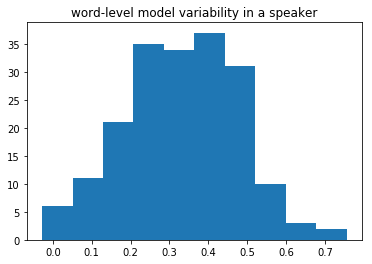

In [68]:
plt.title("word-level model variability in a speaker")
plt.hist(model_scores)

# SV Test

In [75]:
sv_model = si_model
sv_config = si_config.copy()

In [97]:
from scipy.spatial.distance import cosine
def spk_verify(spk_model, test_in, sent_label=None, who=False):
    best_score = -2
    pred_spk = 'Unknown'
    is_unknown = True
    
    
    for spk in spk_model.keys():
        if sent_label is not None:
            signature = spk_model[spk][sent_label]
            signature_uni = np.mean(spk_model[spk],0)
            score = max(1-cosine(test_in, signature), 1-cosine(test_in,signature_uni))
        else:
            signature_uni = spk_model[spk]
            score = 1-cosine(test_in, signature_uni)
            
        if score > best_score:
            best_score = score     
            pred_spk = spk
    if who:
        return pred_spk, best_score
    else:
        return best_score

In [77]:
from sklearn.metrics import roc_curve, auc
def roc_auc_eer(dists, labels):
    """
        dists: 1D-Array, [samples]
        labels: 1D-Array, [samples]
    """
    fpr, tpr, thres = roc_curve(labels, dists, pos_label=1)
    roc_auc = auc(fpr, tpr)
    fnr = 1 - tpr
    eer_ths = thres[np.nanargmin(np.absolute(fnr - fpr))]
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    roc_bundle = {'fpr':fpr, 'tpr':tpr, 'thres':thres}
    np.save(open('roc_data.npy', 'wb'), roc_bundle)

    return roc_auc, eer, eer_ths

In [78]:
test_uttrs = sv_df[(sv_df.spk.isin(test_spks)) & (sv_df.sent.isin(main_sents))].sample(n=len(dev_uttrs))
print("number of dev uttrs: %d"%len(dev_uttrs))
print("number of test uttrs: %d"%len(test_uttrs))

number of dev uttrs: 447
number of test uttrs: 447


In [80]:
# si accuracy based on sv protocol
uni_pos_scores = []
uni_neg_scores = []
speaker_model = uni_spk_models
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    pred_spk, score = spk_verify(uni_spk_models, test_in, None, who = True)
    print(pred_spk, row.spk)
#     score = spk_verify(word_spk_models, test_in, word_label)
    uni_pos_scores.append(score)
    
# for i, row in test_uttrs.iterrows():
#     audio_path = os.path.join(data_dir, row.sent, row.file)
# #     test_in = np.concatenate((hk.embed(sv_config, si_model, audio_path), 
# #                          hk.embed(sv_config, kws_model, audio_path)),axis=1)
#     test_in = hk.embed(sv_config, sv_model, audio_path)
#     word_label = sent_labels.index(row.sent)
#     score = spk_verify(uni_spk_models, test_in)
#     uni_neg_scores.append(score)

# dists = np.concatenate((uni_pos_scores, uni_neg_scores), 0)
# labels = np.concatenate((np.ones_like(uni_pos_scores), np.zeros_like(uni_neg_scores)), 0)
# auc_, eer_, uni_eer_ths = roc_auc_eer(dists, labels)
# print("auc: {}, eer: {}".format(auc_, eer_))

c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
bdee441c c1d39ce8
bdee441c c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c1d39ce8
c1d39ce8 c

In [88]:
uni_pos_scores = []
uni_neg_scores = []
speaker_model = uni_spk_models
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(uni_spk_models, test_in, None)
#     score = spk_verify(word_spk_models, test_in, word_label)
    uni_pos_scores.append(score)
    
for i, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
#     test_in = np.concatenate((hk.embed(sv_config, si_model, audio_path), 
#                          hk.embed(sv_config, kws_model, audio_path)),axis=1)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(uni_spk_models, test_in)
    uni_neg_scores.append(score)

dists = np.concatenate((uni_pos_scores, uni_neg_scores), 0)
labels = np.concatenate((np.ones_like(uni_pos_scores), np.zeros_like(uni_neg_scores)), 0)
auc_, eer_, uni_eer_ths = roc_auc_eer(dists, labels)
print("auc: {}, eer: {}".format(auc_, eer_))

auc: 0.9754915944727215, eer: 0.07829977628635347


(array([  2.,  10.,  24.,  33.,  36.,  40.,  35.,  21.,   9.,   6.]),
 array([-0.0940329 , -0.02653204,  0.04096881,  0.10846966,  0.17597052,
         0.24347137,  0.31097223,  0.37847308,  0.44597394,  0.51347479,
         0.58097565]),
 <a list of 10 Patch objects>)

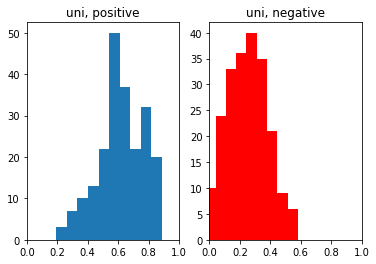

In [78]:
subplot(121)
plt.xlim([0, 1.0])
plt.title("uni, positive")
plt.hist(uni_pos_scores)
subplot(122)
plt.xlim([0, 1.0])
plt.title("uni, negative")
plt.hist(uni_neg_scores, color='r')

In [80]:
word_pos_scores = []
word_neg_scores = []
speaker_model = uni_spk_models
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(word_spk_models, test_in, word_label)
    word_pos_scores.append(score)
    
for i, row in test_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
    score = spk_verify(word_spk_models, test_in, word_label)
    word_neg_scores.append(score)

dists = np.concatenate((word_pos_scores, word_neg_scores), 0)
labels = np.concatenate((np.ones_like(word_pos_scores), np.zeros_like(word_neg_scores)), 0)
auc_, eer_, word_eer_ths = roc_auc_eer(dists, labels)
print("auc: {}, eer: {}".format(auc_, eer_))

auc: 0.967292524005487, eer: 0.09259259259259259


(array([  2.,   7.,  16.,  32.,  31.,  45.,  40.,  25.,  14.,   4.]),
 array([-0.01464383,  0.05175966,  0.11816315,  0.18456664,  0.25097013,
         0.31737362,  0.38377711,  0.45018061,  0.5165841 ,  0.58298759,
         0.64939108]),
 <a list of 10 Patch objects>)

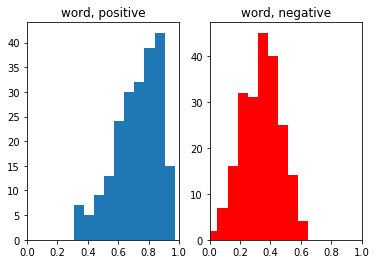

In [81]:
subplot(121)
plt.xlim([0, 1.0])
plt.title("word, positive")
plt.hist(word_pos_scores)
subplot(122)
plt.xlim([0, 1.0])
plt.title("word, negative") 
plt.hist(word_neg_scores, color='r')

In [90]:
uni_fr_samples = dev_uttrs[(np.array(uni_pos_scores) < uni_eer_ths)]
uni_fa_samples = test_uttrs[(np.array(uni_neg_scores) > uni_eer_ths)]
uni_bad_samples = pd.concat([uni_fr_samples, uni_fa_samples])
print("uni_fr: %d, uni_fa: %d"%(len(uni_fr_samples), len(uni_fa_samples)))

uni_fr: 23, uni_fa: 22


In [91]:
word_fr_samples = dev_uttrs[(np.array(word_pos_scores) < word_eer_ths)]
word_fa_samples = test_uttrs[(np.array(word_neg_scores) > word_eer_ths)]
word_bad_samples = pd.concat([word_fr_samples, word_fa_samples])
print("word_fr: %d, word_fa: %d"%(len(word_fr_samples), len(word_fa_samples)))

word_fr: 21, word_fa: 19


In [92]:
# overlapped bad examles
overlap_bad_examples = word_bad_samples[word_bad_samples.index.isin(uni_bad_samples.index)]
print("shared bad examples: %d/%d"%(len(overlap_bad_examples), len(word_bad_samples)))

shared bad examples: 20/40


In [83]:
test_scores = []
print("enrolled_spks:{}".format(enroll_spks))
for i, row in dev_uttrs.iterrows():
    audio_path = os.path.join(data_dir, row.sent, row.file)
    test_in = hk.embed(sv_config, sv_model, audio_path)
    word_label = sent_labels.index(row.sent)
#     score = 1 - cosine(test_in, word_spk_models[row.spk][word_label])
    score = spk_verify(uni_spk_models, test_in, None)
    test_scores.append(score)
    print("{} : {:.2f}".format(row.spk, score))

enrolled_spks:['bdee441c', 'c120e80e', '28ce0c58', 'd0faf7e4', 'c1d39ce8']
c1d39ce8 : 0.76
c1d39ce8 : 0.69
c1d39ce8 : 0.70
c1d39ce8 : 0.69
c1d39ce8 : 0.67
c1d39ce8 : 0.70
c1d39ce8 : 0.67
c1d39ce8 : 0.69
c1d39ce8 : 0.21
c1d39ce8 : 0.80
c1d39ce8 : 0.69
c1d39ce8 : 0.69
c1d39ce8 : 0.64
c1d39ce8 : 0.70
c1d39ce8 : 0.35
c1d39ce8 : 0.70
c1d39ce8 : 0.54
c1d39ce8 : 0.64
c1d39ce8 : 0.41
c1d39ce8 : 0.38
c1d39ce8 : 0.38
c1d39ce8 : 0.79
c1d39ce8 : 0.41
c1d39ce8 : 0.46
c1d39ce8 : 0.37
c1d39ce8 : 0.46
c1d39ce8 : 0.46
c1d39ce8 : 0.58
c1d39ce8 : 0.43
c1d39ce8 : 0.58
c1d39ce8 : 0.80
c1d39ce8 : 0.60
c1d39ce8 : 0.79
c1d39ce8 : 0.82
c1d39ce8 : 0.82
c1d39ce8 : 0.80
c1d39ce8 : 0.84
c1d39ce8 : 0.53
c1d39ce8 : 0.45
c1d39ce8 : 0.53
c1d39ce8 : 0.59
c1d39ce8 : 0.60
c1d39ce8 : 0.69
c1d39ce8 : 0.60
c1d39ce8 : 0.65
c1d39ce8 : 0.69
c1d39ce8 : 0.83
c1d39ce8 : 0.65
c1d39ce8 : 0.83
c1d39ce8 : 0.83
c1d39ce8 : 0.58
c1d39ce8 : 0.75
c1d39ce8 : 0.76
c1d39ce8 : 0.81
c1d39ce8 : 0.72
c1d39ce8 : 0.76
c1d39ce8 : 0.71
c1d39ce8 : 0.

### different ths for each word

In [82]:
for keyword in main_sents:
    word_pos_sample = dev_uttrs[dev_uttrs.sent == keyword]
    word_neg_sample = test_uttrs[test_uttrs.sent == keyword]

    word_pos_scores = []
    word_neg_scores = []
    for i, row in word_pos_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        word_label = sent_labels.index(row.sent)
        score = spk_verify(word_spk_models, test_in, word_label)
        word_pos_scores.append(score)

    for i, row in word_neg_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        word_label = sent_labels.index(row.sent)
        score = spk_verify(word_spk_models, test_in, word_label)
        word_neg_scores.append(score)

    dists = np.concatenate((word_pos_scores, word_neg_scores), 0)
    labels = np.concatenate((np.ones_like(word_pos_scores), np.zeros_like(word_neg_scores)), 0)
    auc_, eer_, _ = roc_auc_eer(dists, labels)
    print("{}: auc: {:.2f}, eer: {:.2f}".format(keyword, auc_, eer_))

yes: auc: 1.00, eer: 0.00
no: auc: 0.99, eer: 0.05
up: auc: 0.89, eer: 0.11
down: auc: 1.00, eer: 0.04
left: auc: 1.00, eer: 0.00
right: auc: 0.99, eer: 0.09
on: auc: 0.99, eer: 0.05
off: auc: 1.00, eer: 0.00
stop: auc: 0.94, eer: 0.19
go: auc: 1.00, eer: 0.00
zero: auc: 0.99, eer: 0.04
one: auc: 0.98, eer: 0.05
two: auc: 0.97, eer: 0.11
three: auc: 1.00, eer: 0.00
four: auc: 0.99, eer: 0.04
five: auc: 1.00, eer: 0.00
six: auc: 0.99, eer: 0.11
seven: auc: 1.00, eer: 0.00
eight: auc: 0.99, eer: 0.08
nine: auc: 0.99, eer: 0.05


### different ths for each speaker

In [95]:
from scipy.spatial.distance import cosine
def one_spk_verify(spk_model, test_in, sent_label=None, who=False):
    best_score = -2
    pred_spk = 'Unknown'
    is_unknown = True
    

    if sent_label is not None:
        signature = spk_model[sent_label]
        signature_uni = np.mean(spk_model[spk],0)
        score = max(1-cosine(test_in, signature), 1-cosine(test_in,signature_uni))
    else:
        signature_uni = spk_model
        score = 1-cosine(test_in, signature_uni)

    if score > best_score:
        best_score = score     
        pred_spk = spk
    if who:co
        return pred_spk, best_score
    else:
        return best_score

In [100]:
for spk in enroll_spks:
    spk_pos_sample = dev_uttrs[dev_uttrs.spk==spk]
    spk_neg_sample = test_uttrs

    spk_pos_scores = []
    spk_neg_scores = []
    for i, row in spk_pos_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        pred_spk, _ = spk_verify(uni_spk_models, test_in, who=True)
        score = one_spk_verify(uni_spk_models[pred_spk], test_in)
        spk_pos_scores.append(score)

    for i, row in spk_neg_sample.iterrows():
        audio_path = os.path.join(data_dir, row.sent, row.file)
        test_in = hk.embed(sv_config, sv_model, audio_path)
        pred_spk, _ = spk_verify(uni_spk_models, test_in, who=True)
        score = one_spk_verify(uni_spk_models[p   red_spk], test_in)
        spk_neg_scores.append(score)

    dists = np.concatenate((spk_pos_scores, spk_neg_scores), 0)
    labels = np.concatenate((np.ones_like(spk_pos_scores), np.zeros_like(spk_neg_scores)), 0)
    auc_, eer_, _ = roc_auc_eer(dists, labels)
    print("{}: auc: {:.2f}, eer: {:.2f}".format(spk, auc_, eer_))

bdee441c: auc: 1.00, eer: 0.00
c120e80e: auc: 0.99, eer: 0.04
28ce0c58: auc: 0.96, eer: 0.09
d0faf7e4: auc: 0.99, eer: 0.07
c1d39ce8: auc: 0.94, eer: 0.12
